### 1. Setup

#### Importing the libraries

In [1]:
import sys, os
sys.path.append(os.pardir)
sys.path.append('./common')

In [2]:
%matplotlib inline

In [3]:
from option import *

In [4]:
print(tf.__version__)
assert tf.__version__>='2.3.0' # Tested with TF 2.3

2.3.0


In [5]:
vars(args)

{'model': 1,
 'fn_pickle': './pickle/class_watch_L_class5_len100_pub.pickle',
 'cuda_device_order': 'PCI_BUS_ID',
 'cuda_visible_devices': '3',
 'dir_out': './out',
 'load_pickle': True,
 'train': True,
 'training_epochs': 100,
 'batch_size': 100}

In [6]:
np.random.seed(1214) 

In [7]:
# If the TensorFlow version lower than 2.3.0, the program will be discontinued.
print(tf.__version__)
assert tf.__version__>='2.3.0'

2.3.0


#### Using the GPU

In [53]:
print(cuda_vis) #gpu idx

3


In [9]:
os.environ["CUDA_DEVICE_ORDER"]=cuda_dev
os.environ["CUDA_VISIBLE_DEVICES"]=cuda_vis # GPU(s) to be used

### 2. Data load

In [10]:
fn_pickle = args.fn_pickle

In [11]:
print(fn_pickle)

./pickle/class_watch_L_class5_len100_pub.pickle


In [12]:
if os.path.exists(fn_pickle):
    print('{} exists....OK'.format(fn_pickle))
    print('loaded the pickle files successfully')
    file = open(fn_pickle, 'rb')
    data = pickle.load(file)
    file.close()

    data_training  = data[0]
    labels_training = data[1]  
    data_test = data[2]  
    labels_test = data[3] 
    class_name_pub = data[4] 
    #features = data[5]
    dt = data[6]
    dname = data[7] 
    #tstring = data[7]
    
    
    n_classes = len(class_name_pub)
    n_input_features = np.shape(data_training)[-1] #datadim
    n_timesteps = data_training.shape[1] #(B, T, D) 
                                         #(7700, 100, 6)
    input_shape=(n_timesteps, n_input_features)
    
else:
    print('Something went wrong !... {} not exists'.format(fn_pickle))

./pickle/class_watch_L_class5_len100_pub.pickle exists....OK
loaded the pickle files successfully


In [13]:
print(dname)
print(n_timesteps, n_input_features, n_classes)

class_watch_L
100 6 5


In [14]:
train = motion.dataset(data_training, labels_training)
train.desc()

Data :  (7700, 100, 6)
Label :  (7700, 5)


In [15]:
test = motion.dataset(data_test, labels_test)
test.desc()

Data :  (3705, 100, 6)
Label :  (3705, 5)


In [16]:
trainX = train.images
trainy = train.labels

testX = test.images
testy = test.labels

### 3. Model train

In [17]:
print(args.train)

True


#### Model selection

In [18]:
args.model

1

In [19]:
print(model_name[args.model])

Conv1D


In [20]:
outDir = '{}/{}_len{}_CL{}_EP{}'.format(base_dir_out,  model_name[args.model], n_timesteps,  n_classes, args.training_epochs)

if not os.path.exists(outDir):
    os.makedirs(outDir)
    print('Created {}'.format(outDir))
else:
    print('Already exists...{}'.format(outDir))

Already exists..../out/Conv1D_len100_CL5_EP100


In [21]:
ttl1 = 'T{}_C{}_Dim{}_{}_EP{}'.format(n_timesteps, n_classes, n_input_features, model_name[args.model], args.training_epochs)
fnmodel = os.path.join(outDir, ttl1+'.h5')
print(fnmodel)

./out/Conv1D_len100_CL5_EP100/T100_C5_Dim6_Conv1D_EP100.h5


In [22]:
if not args.train:
    if not os.path.isfile(fnmodel):
        args.train = True
        print('Model file {} not exists !!'.format(fnmodel))
        print('args.train --> {}'.format(args.train))

    else:
        print('Model file Okay : {}  !!'.format(fnmodel))

In [23]:
from model import make_model

In [24]:
model = make_model(args.model, input_shape, n_classes, model_name[args.model])

In [25]:
print(model.summary())

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 32)           608       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160 

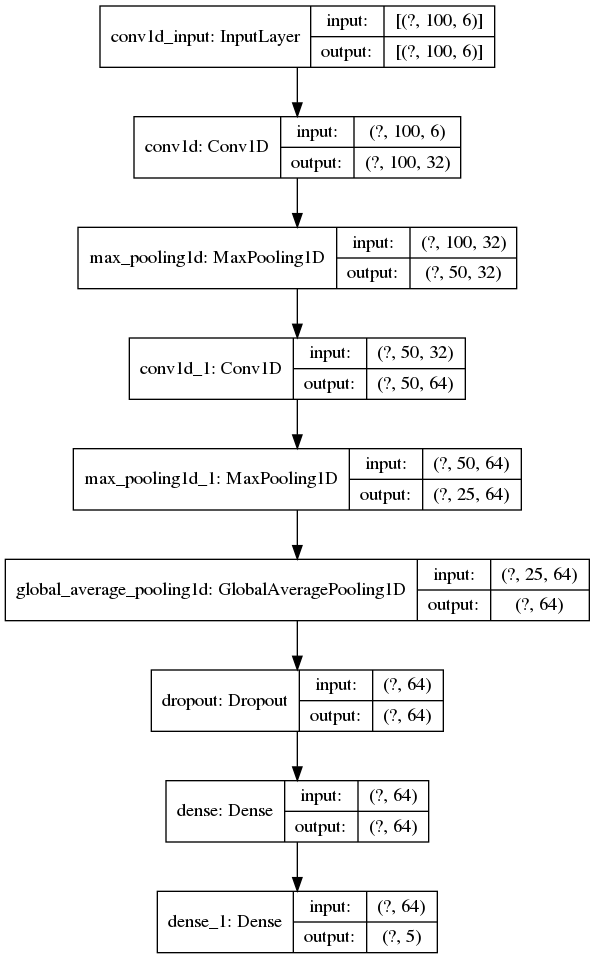

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='{}/model{}.png'.format(outDir, ttl1), show_shapes=True)

from IPython.display import Image
Image('{}/model{}.png'.format(outDir, ttl1))

In [27]:
from ml_util import lr_schedule

In [28]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])

Learning rate:  0.001


#### Callbacks

In [29]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [30]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [31]:
filepath = os.path.join(outDir, 'model')
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

In [32]:
callbacks = [checkpoint, lr_reducer, lr_scheduler]

#### Train the model

In [33]:
if args.train:
    verbose = 1
    history = model.fit(trainX, trainy, epochs=args.training_epochs, batch_size=args.batch_size, verbose=verbose, validation_data=(testX, testy),  callbacks=callbacks)
    model.save(fnmodel)
    print('Saved model..... {}'.format(fnmodel))
    if args.model==2:
        model2.save(fnmodel+"_model2")
        print('Saved model..... {}'.format(fnmodel+"_model2"))
else:
    model = load_model(fnmodel)
    if args.model==2:
        model2 = load_model(fnmodel+"_model2")
    print('Loaded model..... {}'.format(fnmodel))

Learning rate:  0.001
Epoch 1/100
77/77 [==============================] - 1s 7ms/step - loss: 1.1330 - accuracy: 0.5778 - val_loss: 0.9689 - val_accuracy: 0.6278
Learning rate:  0.001
Epoch 2/100
77/77 [==============================] - 0s 6ms/step - loss: 0.9052 - accuracy: 0.6486 - val_loss: 0.8445 - val_accuracy: 0.6918
Learning rate:  0.001
Epoch 3/100
77/77 [==============================] - 0s 6ms/step - loss: 0.8113 - accuracy: 0.6879 - val_loss: 0.7460 - val_accuracy: 0.7323
Learning rate:  0.001
Epoch 4/100
77/77 [==============================] - 0s 6ms/step - loss: 0.7333 - accuracy: 0.7219 - val_loss: 0.7131 - val_accuracy: 0.7220
Learning rate:  0.001
Epoch 5/100
77/77 [==============================] - 0s 6ms/step - loss: 0.6763 - accuracy: 0.7405 - val_loss: 0.6323 - val_accuracy: 0.7611
Learning rate:  0.001
Epoch 6/100
77/77 [==============================] - 0s 6ms/step - loss: 0.6262 - accuracy: 0.7627 - val_loss: 0.5778 - val_accuracy: 0.7757
Learning rate:  0.001


77/77 [==============================] - 0s 6ms/step - loss: 0.2166 - accuracy: 0.9313 - val_loss: 0.2131 - val_accuracy: 0.9385
Learning rate:  0.001
Epoch 27/100
77/77 [==============================] - 0s 6ms/step - loss: 0.2168 - accuracy: 0.9329 - val_loss: 0.2058 - val_accuracy: 0.9412
Learning rate:  0.001
Epoch 28/100
77/77 [==============================] - 0s 6ms/step - loss: 0.2106 - accuracy: 0.9336 - val_loss: 0.2002 - val_accuracy: 0.9401
Learning rate:  0.001
Epoch 29/100
77/77 [==============================] - 0s 6ms/step - loss: 0.2006 - accuracy: 0.9364 - val_loss: 0.1987 - val_accuracy: 0.9444
Learning rate:  0.001
Epoch 30/100
77/77 [==============================] - 0s 6ms/step - loss: 0.1972 - accuracy: 0.9369 - val_loss: 0.1975 - val_accuracy: 0.9436
Learning rate:  0.001
Epoch 31/100
77/77 [==============================] - 0s 6ms/step - loss: 0.1836 - accuracy: 0.9413 - val_loss: 0.1926 - val_accuracy: 0.9439
Learning rate:  0.001
Epoch 32/100
77/77 [=========

77/77 [==============================] - 0s 6ms/step - loss: 0.1166 - accuracy: 0.9642 - val_loss: 0.1442 - val_accuracy: 0.9563
Learning rate:  0.001
Epoch 52/100
77/77 [==============================] - 0s 6ms/step - loss: 0.1148 - accuracy: 0.9623 - val_loss: 0.1323 - val_accuracy: 0.9609
Learning rate:  0.001
Epoch 53/100
77/77 [==============================] - 0s 6ms/step - loss: 0.1188 - accuracy: 0.9623 - val_loss: 0.1352 - val_accuracy: 0.9628
Learning rate:  0.001
Epoch 54/100
77/77 [==============================] - 0s 6ms/step - loss: 0.1153 - accuracy: 0.9657 - val_loss: 0.1353 - val_accuracy: 0.9595
Learning rate:  0.001
Epoch 55/100
77/77 [==============================] - 0s 6ms/step - loss: 0.1104 - accuracy: 0.9638 - val_loss: 0.1353 - val_accuracy: 0.9598
Learning rate:  0.001
Epoch 56/100
77/77 [==============================] - 0s 6ms/step - loss: 0.1056 - accuracy: 0.9660 - val_loss: 0.1290 - val_accuracy: 0.9622
Learning rate:  0.001
Epoch 57/100
77/77 [=========

Learning rate:  0.001
Epoch 77/100
77/77 [==============================] - 0s 6ms/step - loss: 0.0816 - accuracy: 0.9723 - val_loss: 0.1308 - val_accuracy: 0.9630
Learning rate:  0.001
Epoch 78/100
77/77 [==============================] - 0s 6ms/step - loss: 0.0803 - accuracy: 0.9734 - val_loss: 0.1138 - val_accuracy: 0.9671
Learning rate:  0.001
Epoch 79/100
77/77 [==============================] - 0s 6ms/step - loss: 0.0778 - accuracy: 0.9761 - val_loss: 0.1200 - val_accuracy: 0.9671
Learning rate:  0.001
Epoch 80/100
77/77 [==============================] - 0s 6ms/step - loss: 0.0770 - accuracy: 0.9756 - val_loss: 0.1192 - val_accuracy: 0.9665
Learning rate:  0.001
Epoch 81/100
77/77 [==============================] - 0s 6ms/step - loss: 0.0806 - accuracy: 0.9721 - val_loss: 0.1159 - val_accuracy: 0.9663
Learning rate:  0.0001
Epoch 82/100
77/77 [==============================] - 0s 6ms/step - loss: 0.0702 - accuracy: 0.9769 - val_loss: 0.1151 - val_accuracy: 0.9665
Learning rate: 

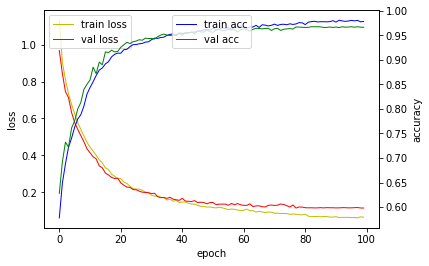

In [34]:
if args.train:
    if tf.__version__>='2.3.0':
        key_acc = 'accuracy'
        key_acc_val = 'val_accuracy'
    else:
        key_acc = 'acc'
        key_acc_val = 'val_acc'
    
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss', linewidth=1)
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss', linewidth=1)
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history[key_acc], 'b', label='train acc', linewidth=1)
    acc_ax.plot(history.history[key_acc_val], 'g', label='val acc', linewidth=1)
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper center')

### 4. Evaluation

In [35]:
pred_train = model.predict(trainX, verbose=1)
pred_test = model.predict(testX, verbose=1)

116/116 [==============================] - 0s 2ms/step


In [36]:
trainy1 = np.argmax(trainy, axis=1)
pred_train1 = np.argmax(pred_train, axis=1)

In [37]:
testy1 = np.argmax(testy, axis=1)
pred_test1 = np.argmax(pred_test, axis=1)

In [38]:
from sklearn.metrics import classification_report
print(model_name[args.model],'(Train result)')
print(classification_report(trainy1, pred_train1, digits=4)) #classification_report(y_true, y_pred)

Conv1D (Train result)
              precision    recall  f1-score   support

           0     0.9885    0.9829    0.9857      1400
           1     0.9937    0.9964    0.9950      1100
           2     0.9877    0.9953    0.9915      3400
           3     0.9847    0.9650    0.9747       800
           4     0.9980    0.9930    0.9955      1000

    accuracy                         0.9897      7700
   macro avg     0.9905    0.9865    0.9885      7700
weighted avg     0.9897    0.9897    0.9897      7700



In [39]:
print(model_name[args.model],'(Test result)')
print(classification_report(testy1, pred_test1, digits=4))

Conv1D (Test result)
              precision    recall  f1-score   support

           0     0.9501    0.9515    0.9508       660
           1     0.9721    0.9858    0.9789       565
           2     0.9705    0.9761    0.9733      1550
           3     0.9560    0.9178    0.9365       450
           4     0.9792    0.9792    0.9792       480

    accuracy                         0.9665      3705
   macro avg     0.9656    0.9621    0.9637      3705
weighted avg     0.9665    0.9665    0.9664      3705



In [40]:
# Model evaluatation
print(model.metrics_names)
score0 = model.evaluate(trainX, trainy, verbose=1)
score = model.evaluate(testX, testy, verbose=1)

print('Train accuracy:', score0[1])
print('Test accuracy:', score[1])

['loss', 'accuracy']
116/116 [==============================] - 0s 3ms/step - loss: 0.1141 - accuracy: 0.9665
Train accuracy: 0.989740252494812
Test accuracy: 0.9665316939353943


In [41]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
from sklearn.metrics import f1_score

# 'micro', 'macro', 'weighted'

f1 = f1_score(trainy1, pred_train1, average='macro')
f1_test = f1_score(testy1, pred_test1, average='macro')

print('Train f1-score: ', f1)
print('Test f1-score: ', f1_test)

Train f1-score:  0.9884838868713572
Test f1-score:  0.9637366275180138


#### Confusion Matrix

In [42]:
conf_matrix = pd.crosstab(trainy1, pred_train1)
print(conf_matrix)

col_0     0     1     2    3    4
row_0                            
0      1376     2    19    3    0
1         1  1096     2    1    0
2         6     1  3384    7    2
3         7     4    17  772    0
4         2     0     4    1  993


In [43]:
conf_matrix = pd.crosstab(testy1, pred_test1) 
print(conf_matrix)

col_0    0    1     2    3    4
row_0                          
0      628    5    18    6    3
1        0  557     3    5    0
2       23    4  1513    6    4
3        9    7    18  413    3
4        1    0     7    2  470


In [44]:
from ml_util import plot_confusion_matrix

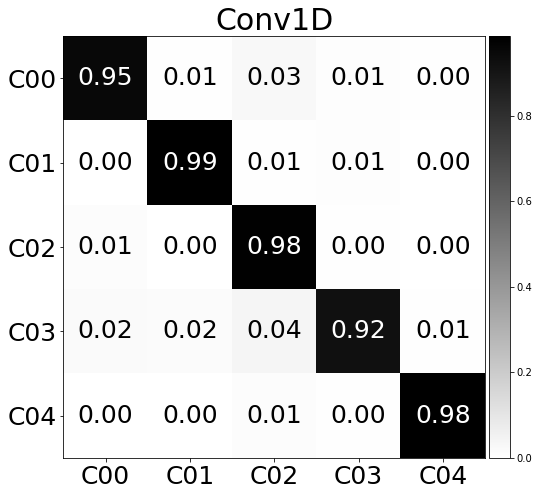

In [45]:
fig_conf = plot_confusion_matrix(testy1, pred_test1, class_name_pub, title='{}'.format(model_name[args.model]),
                                   normalize=True, figsize=(8,8), dpi=72, hide_classname=False, outdir=outDir,
                                   cmap='binary')

#### t-SNE plot

In [46]:
from sklearn.manifold import TSNE

In [47]:
emb_model = Model(model.input, model.layers[-2].output)
emb_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 100, 6)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           608       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)               

In [48]:
embedding = emb_model.predict(testX)
print(embedding.shape)

(3705, 64)


In [49]:
#testy1 = np.argmax(testy, axis=1)
#pred_test1 = np.argmax(pred_test, axis=1)

In [50]:
%%time
proj = TSNE(n_components=2).fit_transform(embedding)
cmp = plt.get_cmap("tab20") 

CPU times: user 1min 33s, sys: 2.25 s, total: 1min 35s
Wall time: 4.15 s


100%|██████████| 5/5 [00:00<00:00, 308.00it/s]

./out/Conv1D_len100_CL5_EP100/embedding_T100_C5_Dim6_Conv1D_EP100.svg


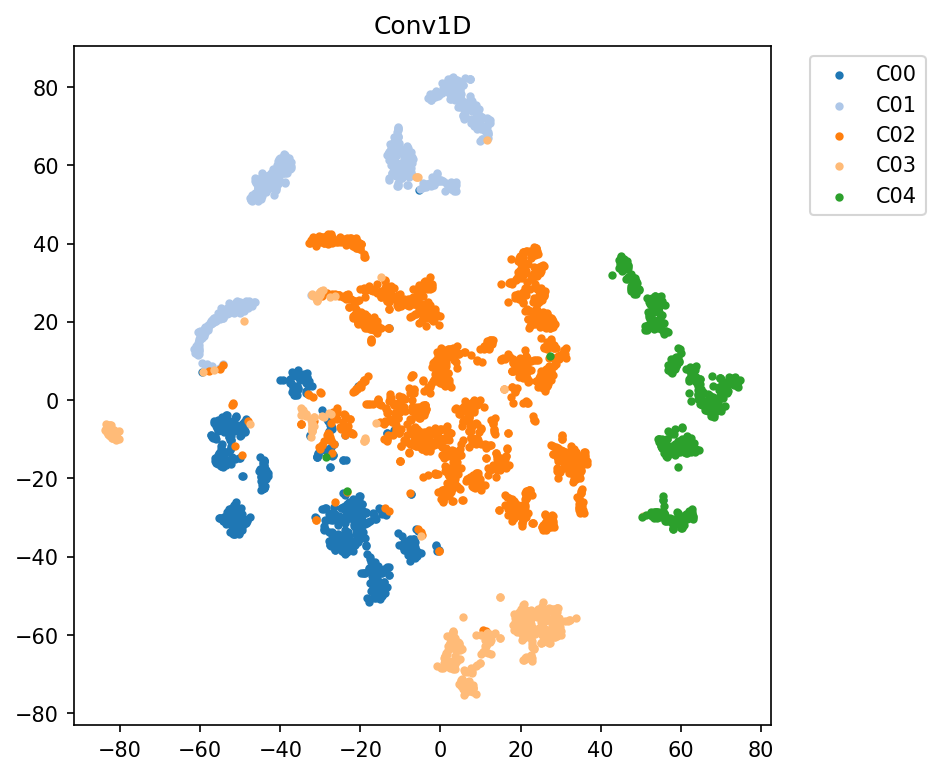

In [51]:
plt.figure(figsize=(6,6), dpi=150)

for i in tqdm(range(n_classes)):
    select_flag = pred_test1 == i
    plt_latent = proj[select_flag, :]
    plt.scatter(plt_latent[:, 0], plt_latent[:, 1], color=cmp(i), marker=".")

plt.title(model_name[args.model])
plt.gca().legend(class_name_pub, bbox_to_anchor=(1.04,1), loc="upper left") 

fnfig = "{}/embedding_{}.svg".format(outDir, ttl1)
print(fnfig)
plt.savefig(fnfig, bbox_inches = "tight")